In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import matplotlib as mpl
sys.path.append('../python/')
os.environ['MPLCONFIGDIR'] = '../mplstyles'


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])

import numpy as np
#set up a plot 
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

# Multiple Scatters for Edelweiss Detector 

In a real detector when calculating the nuclear recoil band from $^{252}$Cf calibration data, we expect there to be multiple-scattering of neutrons. This effect will generally widen the ionization yield distribution of a sample. In that case, it is generally difficult to tell the difference between a widening of the yield distribution resulting from an effective NR Fano factor (the effect we're interested in) and from simply multiple scatters. In general the latter, in the Edelweiss study that we are focusing on, is not large enough to explain the observed ionization yield discrepancies. 

To show this we have simulated neutron-scattering events in the detector of the same size as the Edelweiss detectors (cylindrial with 70 mm diameter and 20 mm thickness). The input spectrum is approximately that which will result from a $^{252}$Cf source. 

The data set comes from a simulation (`Geant4`) with a $^{252}$Cf source and a large amount of local (polyethylene) shielding. This means that the spectrum is a good approximation to one that would be found in a standard shielded low-background apparatus. In particular, one would expect that this is an envrionment which produces a conservative (near maximal) amount of widening because lower-energy neutrons are generally more likely to multiple-scatter. If the detector were exposed to a neutron $^{252}$Cf source with _less_ shielding around the result would almost certainly be that less broadening in the ionization yield distributions would be observed.

The data is stored in an `hdf5` file with the following elements that describe the data set for nuclear recoils. 

key name|NumPy structure|Description 
:-|:-|:-
nr_energies|double array with shape (totalevents,17)|energies of each scatter, up to 17 scatters
nr_hits|integer array with shape (totalevents,)|number of scatters in detector


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
f = h5py.File("/data/chocula/villaa/k100Sim_Data/252Cf/k100_252Cf_shield_Edw_NRs.h5","r")


for i in f['nr_Fano']:
    print(i)

nr_energies
nr_hits


In [3]:
print(np.shape(f['nr_Fano/nr_energies']))
print(np.shape(f['nr_Fano/nr_hits']))

#get the data variables
nr_energies = np.asarray(f['nr_Fano/nr_energies'])
nr_hits = np.asarray(f['nr_Fano/nr_hits'])

nrsum = np.sum(nr_energies*1000,1)
print(np.shape(nrsum))
print(np.shape(nrsum[nrsum>5]))

(106173, 21)
(106173,)
(106173,)
(23615,)


The first and simplest thing we can do with the data is to simply plot the recoil spectrum. This can give us a rather good starting point for understanding the "correct" true-$E_r$ distribution as has been used in the previous notes: `ERNR_bands.ipynb` and `QEr_2D_joint.ipynb`. 

In particular we've used the model:

\begin{equation}
P(E_r) = \frac{1}{\alpha}e^{-\alpha E_r},
\end{equation}

and it has been argued that a good choice for $\alpha$ would be around 1/100 keV$^{-1}$. 

Below, I sum across all of the hits in each event to come up with a distribution in true recoil energy for this $^{252}$Cf simulation. 

In [4]:
#make some histograms

xmax = 100
n_ss,nx_ss = np.histogram(np.sum(nr_energies[nr_hits==1,:],1)*1000,100,range=(0,xmax)) #energies in MeV
n_ms,nx_ms = np.histogram(np.sum(nr_energies[nr_hits>1,:],1)*1000,100,range=(0,xmax))


xc = (nx_ss[:-1] + nx_ss[1:]) / 2

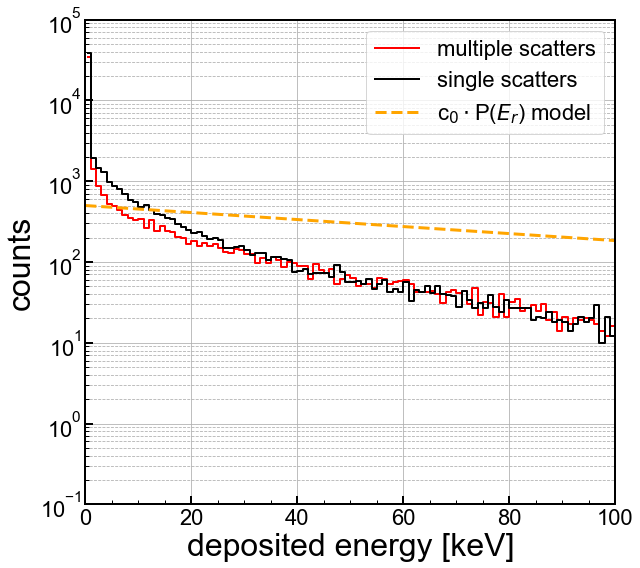

In [5]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

ymin=0.1
ymax=1e4

X = np.arange(0,xmax,0.1)
alpha=1/100.0
PEr = lambda Er: (1/alpha)*np.exp(-alpha*Er)


ax1.step(xc,n_ms, where='mid',color='r', linestyle='-', \
         label='multiple scatters', linewidth=2)
ax1.step(xc,n_ss, where='mid',color='k', linestyle='-', \
         label='single scatters', linewidth=2)
ax1.plot(X,(500*alpha)*PEr(X),color='orange',linestyle='--',linewidth=3,label='c$_0\cdot$P($E_r$) model')




#tlabel = 'Thresh. {0} eV$_{{\mathrm{{ee}}}}$'.format(18)
#ax1.axvline(thresh, color='k', linestyle='--', lw=2, alpha=0.8,label=tlabel)
#erange_x = np.arange(thresh-sigthr, thresh+sigthr, 0.01)
#ax1.fill_between(erange_x, ymin, ymax, facecolor='r', alpha=0.3)

ax1.set_yscale('log')
ax1.set_xlim(0, xmax) #in pairs
ax1.set_ylim(0.1,1e5)
ax1.set_xlabel('deposited energy [keV]',**axis_font)
ax1.set_ylabel('counts',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

The model obviously does not fit the simulated distribution well at all. The simulated distribution _does not_ look like a pure decaying exponential. below about 5 keV the distribution (for both singles and multiples samples) seems to have a much faster decay when the recoil energy is increased. 

Above 5 keV, however, the distribution predicted by the simulation does appear to be close to a single exponential, but not with a decay constant of 1/100 keV$^{-1}$. Below we try a fit to discover a closer value for the decay constant that is reasonable. 

In [6]:
#first compute the errors on each bin with just the counts
err_ss = np.sqrt(n_ss)
err_ms = np.sqrt(n_ms)

#now construct a likelihood function (really just a chisquare)
def lnlike(theta, x, y, yerr):
    a,b = theta
    model = a*(b)*np.exp(-(1/b)*x)
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2))

import scipy.optimize as op
nll = lambda *args: -2*lnlike(*args)

bounds = op.Bounds([0.0,1e-5],[1000.0,1000])
result = op.minimize(nll, [0.1,(100.0)], args=(xc[xc>5], n_ss[xc>5], err_ss[xc>5]),bounds=bounds)
as_ml,bs_ml = result['x']

print(result)

result = op.minimize(nll, [0.1,(100.0)], args=(xc[xc>5], n_ms[xc>5], err_ms[xc>5]),bounds=bounds)
ams_ml,bms_ml = result['x']

print(result)

      fun: 661.8591300633914
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.41060513e-05, -6.82121026e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 114
      nit: 29
   status: 0
  success: True
        x: array([41.09075707, 19.49505089])
      fun: 285.5599909442734
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.70530257e-05, 5.68434189e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 102
      nit: 26
   status: 0
  success: True
        x: array([15.91296867, 26.96001281])


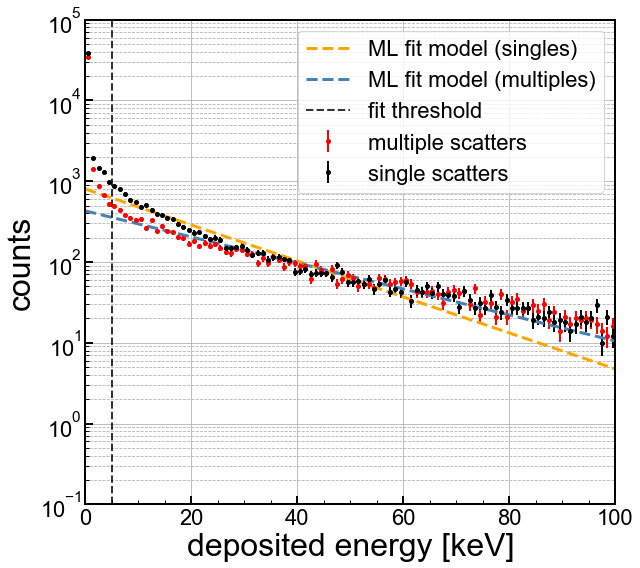

In [7]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

ymin=0.1
ymax=1e4


PEr_s_ml = lambda Er: (as_ml*bs_ml)*np.exp(-(1/bs_ml)*Er)
PEr_ms_ml = lambda Er: (ams_ml*bms_ml)*np.exp(-(1/bms_ml)*Er)


ax1.errorbar(xc,n_ms, yerr=err_ms,color='r', marker='o', \
         markersize=4,linestyle='none',label='multiple scatters', linewidth=2)
ax1.errorbar(xc,n_ss, yerr=err_ss,color='k', marker='o', \
         markersize=4,linestyle='none',label='single scatters', linewidth=2)
#ax1.step(xc,n_ss, where='mid',color='k', linestyle='-', \
#         label='single scatters', linewidth=2)
ax1.plot(X,PEr_s_ml(X),color='orange',linestyle='--',linewidth=3,label='ML fit model (singles)')
ax1.plot(X,PEr_ms_ml(X),color='steelblue',linestyle='--',linewidth=3,label='ML fit model (multiples)')




#tlabel = 'Thresh. {0} eV$_{{\mathrm{{ee}}}}$'.format(18)
ax1.axvline(5, color='k', linestyle='--', lw=2, alpha=0.8,label='fit threshold')
#erange_x = np.arange(thresh-sigthr, thresh+sigthr, 0.01)
#ax1.fill_between(erange_x, ymin, ymax, facecolor='r', alpha=0.3)

ax1.set_yscale('log')
ax1.set_xlim(0, xmax) #in pairs
ax1.set_ylim(0.1,1e5)
ax1.set_xlabel('deposited energy [keV]',**axis_font)
ax1.set_ylabel('counts',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

From the fits above the single-scatter sample has $\alpha$ closer to 1/18 keV$^{-1}$ and the multiple-scatter sample has a value near 1/25 keV$^{-1}$. It is also clear that both samples will fit better to a function that is not a single exponential. It may be true that a "broken" exponential, where the decay parameter changes around 50 keV will work better. 

Since we don't have a need for that kind of precision here we simply recognize that when the singles and the multipe-scatter samples are combined the distribution will be dominated by single scatters below around 40 keV, and the single and multiple scatters could plausibly have the same shape above 40 or 50 keV. Therefore we should chose the best-fitting model for the singles sample, and use $\alpha$=1/18 keV$^{-1}$ where precision in the recoil distribution might be important. 

## Modeling the Ionization Yield of Simulated Data

The `Geant4` simulation we executed does not include the detailed physics of the detector (sometimes called _detector_ Monte Carlo in the SuperCDMS collaboration). Therefore, we must use the individual energy deposits in each particle event (called _hits_) to model the ionization yield, Q, and measured recoil energy, $\tilde{E}_r$. 

In addition to the ionization yield modeling, we will also include modeling of the resolution of the ionization and heat readout, similar to the GGA3 detector of Edelweiss. 

The basic procedure is:

1. calculate the average electron-equivalent energy for every individual hit (scatter) in every individual event
2. calculate the average number of e/h pairs for each hit using the electron-equivalent energy
3. fluctuate the number of e/h pairs based on the variance in the number $\sigma_N = \sqrt{F\bar{N}}$
4. calculate the heat energy for each hit using the number of e/h pairs calculated above (recoil energy plus luke)
5. calculate the ionization energy for each hit using $\epsilon N$ 
6. sum the electron-equivalent energy over all hits in an event to get $E_I$, the total ionization energy
7. sum the heat energy over all hits in an event to get $E_H$, the total heat energy
8. add a random amount distributed like $N(0,\sigma_I(E_I))$ to the ionization energy
9. add a random amount distributed like $N(0,\sigma_H(E_H))$ to the total phonon energy
10. calculate the measured recoil energy for each event as $\tilde{E}_r = (1+(V/\epsilon))E_H - (V/\epsilon)E_I$
11. calculate the ionization yield for each event like $Q = E_I/\tilde{E}_r$


In [8]:
#constants
V=4.0 #volts
eps = 3.0/1000 #keV per pair, I usually use 3.3 for the numerator, but Edw. uses 3.
FWHM_to_SIG = 1 / (2*np.sqrt(2*np.log(2)))

#yield models
a=0.16
b=0.18
Qbar = lambda Er: a*Er**b

In [9]:
#start getting the resolutions
import EdwRes as er

#heatRes_GGA3 = er.get_heatRes_func(0.4, 2.7,aH*FWHM_to_SIG)
heatRes_GGA3 = er.get_heatRes_func(0.4, 2.7)

sigI_GGA3 = er.get_ionRes_func(1.3, 1.5, 3.1)

sigh_GGA3v = np.vectorize(heatRes_GGA3)
sigi_GGA3v = np.vectorize(sigI_GGA3)

In [10]:
#include a nominal Fano factor
F=0.0 #for NRs the factor is probably much higher than this

Enr = nr_energies*1000 #initial energies are in MeV
Enr_ss = nr_energies[nr_hits==1]*1000 #initial energies are in MeV

#step 1
EIhit_av = Qbar(Enr)*Enr
EIhit_av_ss = Qbar(Enr_ss)*Enr_ss

#step 2
Nhit_av = EIhit_av/eps
Nhit_av_ss = EIhit_av_ss/eps

#step 3
Nhit = np.around(np.random.normal(Nhit_av,np.sqrt(F*Nhit_av))).astype(np.float)
Nhit_ss = np.around(np.random.normal(Nhit_av_ss,np.sqrt(F*Nhit_av_ss))).astype(np.float)

#step 4
EHhit = (Enr + Nhit*V/1000.0)/(1+(V/(1000*eps)))
EHhit_ss = (Enr_ss + Nhit_ss*V/1000.0)/(1+(V/(1000*eps)))

#step 5
EIhit = eps*Nhit
EIhit_ss = eps*Nhit_ss

#step 6
EI = np.sum(EIhit,1)
EI_ss = np.sum(EIhit_ss,1)

#step 7
EH = np.sum(EHhit,1)
EH_ss = np.sum(EHhit_ss,1)

#step 8
EI = EI + np.random.normal(0.0,sigi_GGA3v(EI))
EI_ss = EI_ss + np.random.normal(0.0,sigi_GGA3v(EI_ss))

#step 9
EH = EH + np.random.normal(0.0,sigh_GGA3v(EH))
EH_ss = EH_ss + np.random.normal(0.0,sigh_GGA3v(EH_ss))

#step 10
Ernr = (1+(V/(1000*eps)))*EH - (V/(1000*eps))*EI
Ernr_ss = (1+(V/(1000*eps)))*EH_ss - (V/(1000*eps))*EI_ss

#step 11
Q = EI/Ernr
Q_ss = EI_ss/Ernr_ss


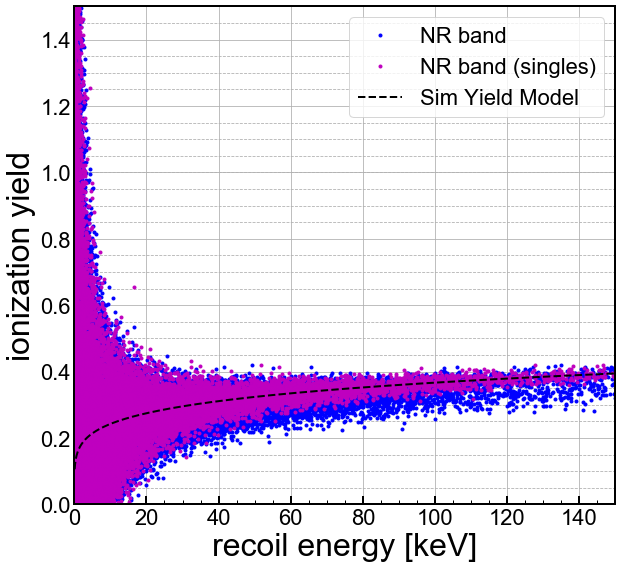

In [11]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


X = np.arange(0.1,150,0.1)
#ax1.plot(Erer,Yer,'o',color='k', label='ER band',linewidth=2,markersize=3)
ax1.plot(Ernr,Q,'o',color='b', label='NR band',linewidth=2,markersize=3)
ax1.plot(Ernr_ss,Q_ss,'o',color='m', label='NR band (singles)',linewidth=2,markersize=3)
ax1.plot(X,Qbar(X),'k--',label='Sim Yield Model')

#ax1.plot(X,ynr_muv(X),'r--',label='NR mu')
#ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\\sigma$')
#ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

#ax1.plot(X,yer_muv(X),color='orange',linestyle='--',label='ER mu')
#ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='orange',linestyle='-',label='ER 3$\\sigma$')
#ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='orange',linestyle='-',label=None)



#ax1.axvline(t(t_test[idx]), color='k', linestyle='-', lw=2, alpha=0.8,label=None)


ymin = 0
ymax = 1.5



ax1.set_yscale('linear')
#ax1.set_yscale('linear')
ax1.set_xlim(0, 150) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

The figure above shows the Q,$\tilde{E}_r$ distribution for all recoils (blue) and for only single-scatters (magenta). It is clear that there is some broadening due to multiple-scattering. The broadening is rather modest compared to what was observed in Edelweiss [REF] but we seek to quantify it in this note, and devise a systematic correction for the width increase that Edelweiss has measured to the "effective single-scatter width increase." It is this latter quantity that is directly related to the energy-dependent effective Fano factor for nulcear recoils.  

## Energy-Binned Yield Distribution Fitting

By using a set of bins in recoil-energy, $\tilde{E}_r$, we can use the simulated data above to quantify the effect of multiple scattering on the yield distributions. 

In order to emulate the points in the Edelweiss paper [REF], we construct energy bins the same as in the paper. 

energy bin|interval (keV)
:-|:-
0|\[5,10)
1|\[10,20)
2|\[20,30)
3|\[30,40)
4|\[40,50)
5|\[50,70)
6|\[70,150)

In the lowest bin we use a threshold of 5 keV because below that is not useful. As a matter of fact, the fits are only utilized in the 6 higher energy bins because we are primarily interested in behavior above 10 keV. 

For each energy bin, we plot the ionization yield projection histogram and fit a Gaussian model to it to extract the approximate width (1$\sigma$ interval) and the uncertainty on this width. 

In [12]:
import pandas as pds

#create a dataframe
nr_df = pds.DataFrame(data={'yield':Q, 'energy':Ernr})
nr_ss_df = pds.DataFrame(data={'yield':Q_ss, 'energy':Ernr_ss})

#bin the data
bins = [5, 10, 20, 30, 40, 50, 70,150]
nr_df['binned'] = pds.cut(nr_df['energy'],bins)
nr_ss_df['binned'] = pds.cut(nr_ss_df['energy'],bins)

#print stats in each bin
s = nr_df.groupby(pds.cut(nr_df['energy'], bins=bins)).size()
s_ss = nr_ss_df.groupby(pds.cut(nr_ss_df['energy'], bins=bins)).size()
print (s)
print(s_ss)

#create list of vectors for histogrammin'
hist = nr_df.groupby(pds.cut(nr_df['energy'], bins=bins))['yield'].apply(list)
hist_ss = nr_ss_df.groupby(pds.cut(nr_ss_df['energy'], bins=bins))['yield'].apply(list)
print(hist)
print(hist_ss)

energy
(5, 10]      5597
(10, 20]     6215
(20, 30]     3412
(30, 40]     2195
(40, 50]     1520
(50, 70]     1948
(70, 150]    2379
dtype: int64
energy
(5, 10]      3558
(10, 20]     3776
(20, 30]     1869
(30, 40]     1149
(40, 50]      723
(50, 70]      966
(70, 150]    1128
dtype: int64
energy
(5, 10]      [0.25820691815741864, 0.22910280585491866, 0.4...
(10, 20]     [0.16043933196178564, 0.08587800449375128, 0.2...
(20, 30]     [0.2613678872451344, 0.2929460643197061, 0.253...
(30, 40]     [0.2615310254902713, 0.2968598680277387, 0.252...
(40, 50]     [0.2913862088161614, 0.33969420958267116, 0.34...
(50, 70]     [0.2716822377760131, 0.27235686974059264, 0.34...
(70, 150]    [0.3648542356594809, 0.2839917385989442, 0.355...
Name: yield, dtype: object
energy
(5, 10]      [0.3217254960590607, 0.263416292879715, 0.0095...
(10, 20]     [0.343605856956998, 0.12585820101237405, 0.182...
(20, 30]     [0.3193661821193253, 0.29080906266347306, 0.31...
(30, 40]     [0.3032354947672357, 0.3

In [13]:
#make a lot of histograms
qbins = np.linspace(0,0.6,40)
xcq = (qbins[:-1] + qbins[1:]) / 2

qhistos = np.zeros((np.shape(qbins)[0]-1,0))
qhistos_ss = np.zeros((np.shape(qbins)[0]-1,0))
qerrs = np.zeros((np.shape(qbins)[0]-1,0))
qerrs_ss = np.zeros((np.shape(qbins)[0]-1,0))

qamps = np.zeros((np.shape(bins)[0]-1,))
qamps_ss = np.zeros((np.shape(bins)[0]-1,))
qmus = np.zeros((np.shape(bins)[0]-1,))
qmus_ss = np.zeros((np.shape(bins)[0]-1,))
qsigs = np.zeros((np.shape(bins)[0]-1,))
qsigs_ss = np.zeros((np.shape(bins)[0]-1,))
qsigerrs = np.zeros((np.shape(bins)[0]-1,))
qsigerrs_ss = np.zeros((np.shape(bins)[0]-1,))


for i,Qv in enumerate(hist):
    n,nx = np.histogram(Qv,bins=qbins)
    n = np.reshape(n,(np.shape(n)[0],1))
    qhistos = np.append(qhistos,n,axis=1)
    qerrs = np.append(qerrs,np.sqrt(n),axis=1)
    qerrs[qerrs==0]=1
    
for i,Qv in enumerate(hist_ss):
    n,nx = np.histogram(Qv,bins=qbins)
    n = np.reshape(n,(np.shape(n)[0],1))
    qhistos_ss = np.append(qhistos_ss,n,axis=1)
    qerrs_ss = np.append(qerrs_ss,np.sqrt(n),axis=1)
    qerrs_ss[qerrs_ss==0]=1

    
#now construct a likelihood function (really just a chisquare)
def lnlikeg(theta, x, y, yerr):
    a,b,c = theta
    model = a*np.exp(-(x-b)**2/(2*c**2))
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2))


nllg = lambda *args: -2*lnlikeg(*args)

#also construct a residual function for use with lmfit
import lmfit as lmf

def residual(params, x, data, eps_data):
    amp = params['amp']
    mean = params['mean']
    sig = params['sig']


    model = amp * np.exp(-(x-mean)**2/(2*sig**2))

    return (data-model) / eps_data


startamps = [0.1,0.1,0.1,0.1,0.05,0.02,0.03]
startmus = [0.25,0.25,0.3,0.3,0.3,0.35,0.34]
startsigs = [0.1,0.1,0.05,0.05,0.05,0.05,0.03]

for i,h in enumerate(hist):
  print('fitting {}'.format(i))

  #do it with scipy optimize
  bounds = op.Bounds([0.0,0.001,1e-6],[100,1.0,1.0])
  qsum = np.sum(qhistos[:,i])
  result = op.minimize(nllg, [startamps[i],startmus[i],startsigs[i]], args=(xcq, qhistos[:,i]/qsum, qerrs[:,i]/qsum),bounds=bounds)
  qamps[i],qmus[i],qsigs[i] = result['x']
  print('SCIPY result--multiples')
  print(result['x'])
  qsum_ss = np.sum(qhistos_ss[:,i])
  result = op.minimize(nllg, [startamps[i],startmus[i],startsigs[i]], args=(xcq, qhistos_ss[:,i]/qsum_ss, qerrs_ss[:,i]/qsum_ss),bounds=bounds)
  qamps_ss[i],qmus_ss[i],qsigs_ss[i] = result['x']
  print('SCIPY result--singles')
  print(result['x'])
  
  #do it with lmfit
  params = lmf.Parameters()
  params.add('amp', value=startamps[i])
  params.add('mean', value=startmus[i])
  params.add('sig', value=startsigs[i])
  lmfout = lmf.minimize(residual, params, args=(xcq, qhistos[:,i]/qsum, qerrs[:,i]/qsum))
  #print(lmf.fit_report(lmfout))
  print('lmfit result--multiples')
  print(lmf.report_fit(lmfout.params))
  qsigs[i] = lmfout.params['sig'].value
  qsigerrs[i] = np.sqrt(lmfout.covar[2,2])

  params = lmf.Parameters()
  params.add('amp', value=startamps[i])
  params.add('mean', value=startmus[i])
  params.add('sig', value=startsigs[i])
  lmfout = lmf.minimize(residual, params, args=(xcq, qhistos_ss[:,i]/qsum_ss, qerrs_ss[:,i]/qsum_ss))
  #print(lmf.fit_report(lmfout))
  print('lmfit result--singles')
  print(lmf.report_fit(lmfout.params))
  qsigs_ss[i] = lmfout.params['sig'].value
  qsigerrs_ss[i] = np.sqrt(lmfout.covar[2,2])
  #print(lmfout.params['sig'])
  #print(lmfout.covar)
  #print(np.sqrt(lmfout.covar[2,2]))
  #print(np.sqrt(np.sum(lmfout.covar[2,:]**2)))

print(qsigs)
print(qsigerrs)
print(qsigs_ss)
print(qsigerrs_ss)

fitting 0
SCIPY result--multiples
[0.04283277 0.19755554 0.16104914]
SCIPY result--singles
[0.04311087 0.2077994  0.15569494]
lmfit result--multiples
[[Variables]]
    amp:   0.04283277 +/- 7.3319e-04 (1.71%) (init = 0.1)
    mean:  0.19755556 +/- 0.00334551 (1.69%) (init = 0.25)
    sig:   0.16104913 +/- 0.00287951 (1.79%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(mean, sig) = -0.590
    C(amp, sig)  = -0.582
    C(amp, mean) =  0.191
None
lmfit result--singles
[[Variables]]
    amp:   0.04311087 +/- 0.00102102 (2.37%) (init = 0.1)
    mean:  0.20779939 +/- 0.00407879 (1.96%) (init = 0.25)
    sig:   0.15569497 +/- 0.00361070 (2.32%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, sig)  = -0.603
    C(mean, sig) = -0.519
    C(amp, mean) =  0.181
None
fitting 1
SCIPY result--multiples
[0.07089123 0.24231378 0.08606329]
SCIPY result--singles
[0.06842668 0.25182008 0.08887764]
lmfit result--multiples
[[Variables]]
    amp:  

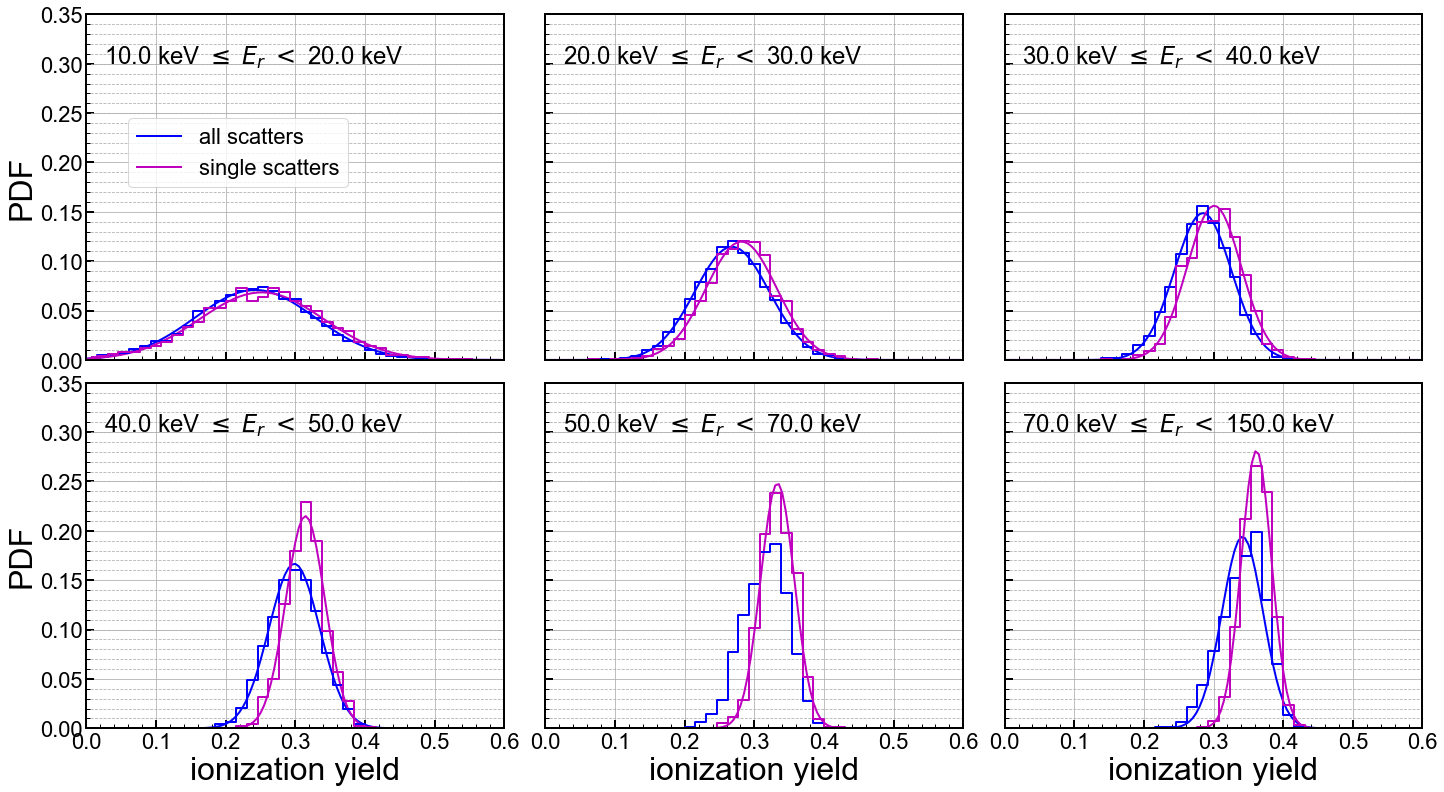

In [14]:
fig,axs = plt.subplots(2,3,figsize=(20.0,11.0),sharex=True,sharey=True)

X = np.arange(0,0.6,0.005)
func = lambda x,a,b,c: a*np.exp(-(x-b)**2/(2*c**2))
funcv = np.vectorize(func)

for i,ax in enumerate(np.ndarray.flatten(axs)):
    #ax.set_title('markevery=%s' % str(case))
    #ax.plot(x, y, 'o', ls='-', ms=4, markevery=case)
    ax.text(0.025,0.3,"{:2.1f} keV $\leq$ $E_r$ $<$ {:2.1f} keV".format(bins[i+1],bins[i+2]),fontsize=24)
    idx=i+1
    ax.plot(X,funcv(X,qamps[i+1],qmus[i+1],qsigs[i+1]),color='b',linestyle="-",linewidth=2)
    ax.plot(X,funcv(X,qamps_ss[i+1],qmus_ss[i+1],qsigs_ss[i+1]),color='m',linestyle="-",linewidth=2)
    ax.step(xcq,qhistos[:,idx]/np.sum(qhistos[:,idx]), where='mid',color='b', linestyle='-', \
            label='all scatters', linewidth=2)
    ax.step(xcq,qhistos_ss[:,idx]/np.sum(qhistos_ss[:,idx]), where='mid',color='m', linestyle='-', \
            label='single scatters', linewidth=2)
    ax.set_yscale('linear')
    #ax1.set_yscale('linear')
    ax.set_xlim(0, 0.6) 
    ax.set_ylim(0,0.35)
    if(i>2):
      ax.set_xlabel(r'ionization yield',**axis_font)
    if((i==0)|(i==3)):
      ax.set_ylabel('PDF',**axis_font)
    ax.grid(True)
    ax.yaxis.grid(True,which='minor',linestyle='--')
    if(idx==1):
      ax.legend(loc=(0.1,0.5),prop={'size':22})
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
 
plt.tight_layout() 
plt.show()

In each of the energy bins the ionization yield distribution fit results are summarized in the following table. 

energy bin|interval (keV)|all-scatters width (keV)|all-scatters uncertainty (keV)|single-scatters width (keV)| single-scatters uncertainty (keV)
:-|:-|:-|:-
0|\[5,10)| 0.164 | 0.004 | 0.150 | 0.004
1|\[10,20)|0.087 | 0.001 | 0.086 |0.001
2|\[20,30) | 0.053 |0.001 |0.051 | 0.001
3|\[30,40) | 0.040 |0.001 |0.037 |0.001
4|\[40,50) | 0.035 | 0.000 |0.032 |0.001
5|\[50,70) | 0.030 | 0.001 |0.025 |0.000
6|\[70,150) |0.029 | 0.001 |0.023 |0.000



below are some cells that show how to use emcee

In [15]:
# #show the errors on a fit
# #https://emcee.readthedocs.io/en/v2.2.1/user/line/#maximum-likelihood-estimation
# def lnprior(theta):
#     a, b, c = theta
#     if 0.0 < a < 100 and 0.00001 < b < 1.0 and 1e-6 < c < 1.0:
#         return 0.0
#     return -np.inf

# def lnprob(theta, x, y, yerr):
#     lp = lnprior(theta)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + lnlikeg(theta, x, y, yerr)

# ndim, nwalkers = 3, 100
# pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]



In [16]:
# qsum = np.sum(qhistos[:,1])
# x = xcq
# y = qhistos[:,1]/qsum
# yerr = qerrs[:,1]/qsum


# import emcee
# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

# sampler.run_mcmc(pos, 5000);

In [17]:
# samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

# import corner
# #fig = corner.corner(samples, labels=["$a$", "$b$", "$c$"],
# #                      truths=[qamps[1], qmus[1], qsigs[1]])
# fig = corner.corner(samples, labels=["$a$", "$b$", "$c$"])

## Multiple-Scatter Systematic

The Edelweiss paper quotes the enlargement of the ionization-yield width as a simple factor, constant across all recoil energy bins. They call this factor "C." Based on the results in this note, it is sensible to quote an energy-dependent systematic uncertainty on top of that constant factor. This will impact the energy-dependent systematic uncertainty on our extracted Fano factor. 

The reason it makes sense to proceed this way is that the correction to the width is small, at most 0.006, whereas the value of "C" that we are attributing to the effective nuclear-recoil Fano factor, is around 0.04 across all energies. Quoting this as a systematic will underscore the fact that this is a relatively inprecise extraction, whereas if we were to correct the width for multiple scatters, it may lead to a misleading assessement of the final uncertainty on the extracted effective nuclear-recoil Fano factor. 

Recall, that in the Edelweiss paper [REF], a Gaussian approximation was used wherein the width in ionization yield could be written as:

\begin{equation}
\sigma_Q(\tilde{E}_r) \simeq \frac{1}{\tilde{E}_r} \sqrt{\left(1+\frac{V}{\epsilon}\bar{Q}\right)^2\sigma_I^2 + \left(1+\frac{V}{\epsilon}\right)^2\bar{Q}^2\sigma_H^2}.
\end{equation}

For comparison, we can plot this along with our measured widths for detector GGA3. 

In [18]:
#make functions for analytical bands
#modify heat resolution by adding aH

aH=0.065
heatRes_GGA3_new = er.get_heatRes_func(0.4, 2.7,aH*FWHM_to_SIG)
#heatRes_GGA3_new = er.get_heatRes_func(0.4, 2.7)
sigh_GGA3v_new = np.vectorize(heatRes_GGA3_new)

#new resolution functions 
Ehee = lambda Er: ((1+(V/(1000*eps))*Qbar(Er))*Er)/(1+(V/(1000*eps)))
EIee = lambda Er: Qbar(Er)*Er


sigH_NR = lambda Er: sigh_GGA3v_new(Ehee(Er))

sigI_NR = lambda Er: sigi_GGA3v(EIee(Er))


#sigQnr = lambda Etr: (1/Etr)*np.sqrt((1+(V/(1000*eps))*Qbar(Etr))**2*sigI_NR(Etr)**2 + (1+(V/(1000*eps)))**2 \
#                                     *Qbar(Etr)**2*sigH_NR(Etr)**2) 
sigQnr = lambda Etr: (1/Etr)*np.sqrt((1+(V/(1000*eps))*Qbar(Etr))**2*sigI_NR(Etr)**2 + (1+(V/(1000*eps)))**2 \
                                     *Qbar(Etr)**2*sigH_NR(Etr)**2)


print(sigQnr(20))
print(sigH_NR(10))
print(sigI_NR(10))
sigQnrv = np.vectorize(sigQnr)

0.05881961755608948
0.23096523083266213
0.8431667681790007


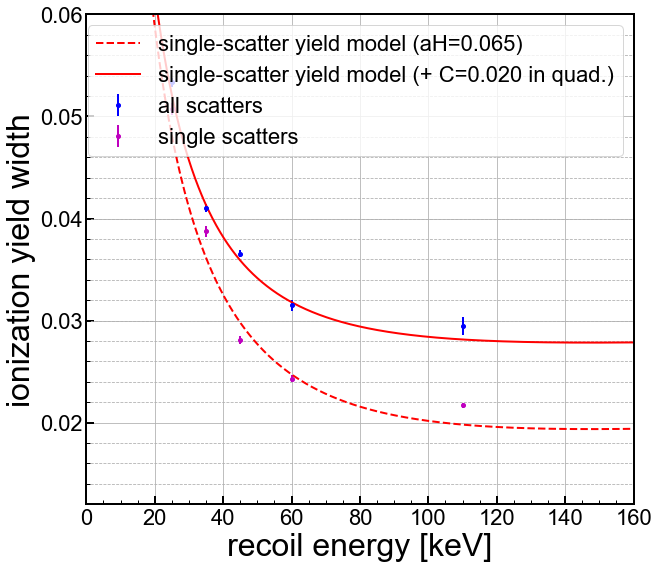

In [19]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


bins = np.asarray(bins)
xE = (bins[:-1] + bins[1:]) / 2

X=np.arange(0.1,160,0.1)


ax1.plot(X,sigQnrv(X),color='r',linestyle="--",linewidth=2,label='single-scatter yield model (aH={:1.3})'.format(aH))
ax1.plot(X,np.sqrt(sigQnrv(X)**2+0.02**2),color='r',linestyle="-",linewidth=2,\
         label='single-scatter yield model (+ C={:1.3f} in quad.)'.format(0.02))
ax1.errorbar(xE,qsigs, yerr=qsigerrs,color='b', marker='o', \
         markersize=4,linestyle='none',label='all scatters', linewidth=2)
ax1.errorbar(xE,qsigs_ss, yerr=qsigerrs_ss,color='m', marker='o', \
         markersize=4,linestyle='none',label='single scatters', linewidth=2)



ymin = 0.012
ymax = 0.06



ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(0, 160) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield width',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})
#ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

There are some puzzling features of these results in comparison with the Edw. model predictions (red curves above). Even though we used a F=0 throughout, the simulated data is larger than the model that Edw. predicts by a substantial amount, even after using the increased $a_H$ of 0.035 mentioned in their paper for GGA3. In fact an $a_H$ of 0.065 seems to be a closer approximation. 

Of course, this is the _nuclear_ recoil band with single-scatters only. The Edw. paper doesn't have any way to check what the prediction should be for a nuclear recoil band would be _without_ the effective Fano factor and with only single-scatters. It is possible that our model prediction (and hence our simulated data) is systematically wider for the NR band than the Gaussian model used by Edw. 

Probably the best way to check this is to:

1. extract the widths for the ER band model from simulated data.
2. plot over those the 1$\sigma$ lines for both the Edw. model and our v2 model with F=0. We expect our model to agree with the simulated data, and we believe the method of simulation above is close to physical. 
3. make the same checks for the NR bands. 

Note the only real difference between the ER and NR bands with F=0 is the assumed energy spectrum (flat for ERs and exponential for NRs) and point of evaluation of the resolutions (i.e. need to use electron-equivalent for the $\sigma_I$ evaluation).

These checks should be done in a separate note. 

Finally, it can be seen from the above plot that adding a constant widening factor (in quadrature) of C=0.02 on top of an $a_H$ of 0.065 will give widths roughly consistent with the full recoil sample (i.e. including multiple-scatters). This value of C is less than the quoted average of 0.04 by about a factor of 2. Therefore after an arbitrary upward empirical correction to the single-scatter yield widths the observed bands are wider by a quadrature addition of 0.02. 

The multiple-scatter predictions for the model are still well short of the final widths reported by Edelweiss, so there is room for an effective nuclear-recoil Fano contribution. 